# pyIsoDep

Copyright (c) Dan Kotlyar <br>
Author: Matt Krecicki

# Post processing features example

##  Description

Example detailing post processing features available in pyIsoDep using simplied Xenon chain example.

## Load modules

In [1]:
import numpy as np
from pyIsoDep.functions.maindepletionsolver import MainDepletion
from pyIsoDep.functions.generatedata import TransmutationData
from pyIsoDep.functions.postprocessresults import Results

### Define xenon- and samarium- data

In [2]:
ID = [531350, 541350, 611490, 621490, 922350, 922380]
sig_c = [6.8, 250537.62, 132.47, 6968.75, 5.0, 8.0]
sig_f = [0.0, 0.0000000, 0.000, 0.00000, 97., 3.8]
kappa = [0.0, 0.0000000, 0.000, 0.00000, 202.44, 202.44]
N0 = [0.0, 0.0000000, 0.000, 0.00000, 6.43230E-04, 2.58062E-03]

#    531350, 541350, 611490, 621490, 922350, 922380
mtxFY = [
    [0.0000, 0.0000, 0.0000, 0.0000, 0.06306, 0.06306],  # 531350
    [0.0000, 0.0000, 0.0000, 0.0000, 0.00248, 0.00248],  # 541350
    [0.0000, 0.0000, 0.0000, 0.0000, 0.01100, 0.01100],  # 611490
    [0.0000, 0.0000, 0.0000, 0.0000, 0.00000, 0],  # 621490
    [0.0000, 0.0000, 0.0000, 0.0000, 0.00000, 0],  # 922350
    [0.0000, 0.0000, 0.0000, 0.0000, 0.00000, 0],  # 922380
    ]

### Data Generation Stage

In [3]:
# Reset the data container
data = TransmutationData(libraryFlag=True, wgtFY=1.0)
# Feed cross sections into the container
data.ReadData(ID, sig_f=sig_f, sig_c=sig_c, fymtx=mtxFY, EfissMeV=kappa)
# Condense the data only to specific set of isotopes
data.Condense(ID)

### Depletion Stage

#### Define metadata

In [4]:
volume = 332097.750  # volume in cm**3

timepoints = np.linspace(0, 48.0, 24)
power = 330000000.*np.ones(len(timepoints)-1)  # Watts

#### Execute Depletion

In [5]:
dep = MainDepletion(0.0, data)
dep.SetDepScenario(power=power, timeUnits="hours", timepoints=timepoints)
# set initial composition
dep.SetInitialComposition(ID, N0, vol=volume)
# solve the Bateman equations
dep.SolveDepletion(method="cram")

#### Post depletion analysis

In [6]:
dep.DecayHeat()
dep.Radiotoxicity()
dep.Activity()
dep.Mass()
dep.Reactivity()

### Post-process results

This function creates depletion results container

In [7]:
res = Results(dep)

#### Write to and read from Hdf5 file

The export function writes the depletion analysis to an hdf5 file, which can be used to reconstruct the results object. An example is shown below. 

In [8]:
res.export("results.h5", includeXS=True) #write to hdf5
res2 = Results("results.h5", includeXS=True)             #read from hdf5

All of the methods of the results object are retained when the results are read from hdf5 file

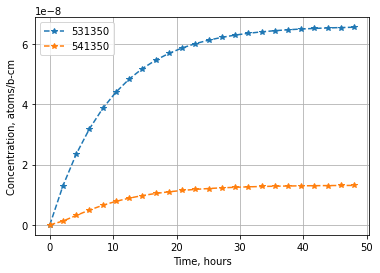

In [9]:
res2.plot("Nt", timeUnits="hours", isotopes=[531350,541350], ylabel="Concentration, atoms/b-cm")

#### Ranking function

In addition to the plotting feature, a ranking function that will rank each isotopes integral contribution to the total of a given output value. This feature is useful for understanding a specific isotopes contribution for the simplification of a depletion matrix to increase computational efficiency. <br>

The parameters that can be ranked are the following: <br>
- "Qt" (decay heat)
- "reactivity" 
- "At" (activity)
- "toxicityIngestion"
- "toxicityInhalation"

In [10]:
rankQt = res2.rank("Qt")
rankQt.head()

,Id,ZAI,Qt,cumlative sum
0,531350,I-135,3.789714e+06,0.951557
1,541350,Xe-135,1.514217e+05,0.989578
2,611490,Pm-149,4.150816e+04,1.000000
4,922350,U-235,1.194941e-01,1.000000
5,922380,U-238,6.929904e-02,1.000000


In [11]:
rankRho = res2.rank("reactivity")
rankRho.head(6)

,Id,ZAI,reactivity,cumlative sum
4,922350,U-235,1.595336e+06,0.664723
5,922380,U-238,7.428881e+05,0.974260
1,541350,Xe-135,6.090010e+04,0.999635
3,621490,Sm-149,7.908624e+02,0.999965
2,611490,Pm-149,7.631954e+01,0.999996
0,531350,I-135,8.617606e+00,1.000000


In addition to the integral quanity being ranked, the parameter at a specific time can also be ranked. The time point that is entered does not have to exactly the time points of the simulation, pyIsoDep will automatically find the closest time point. 

In [12]:
rankRho2 = res2.rank("reactivity", timepoint=40.0, timeUnit="hours")
rankRho2.head(6)

,Id,ZAI,reactivity,cumlative sum
4,922350,U-235,65897.623270,0.658976
5,922380,U-238,30753.058344,0.966507
1,541350,Xe-135,3279.534709,0.999302
3,621490,Sm-149,64.329736,0.999945
2,611490,Pm-149,5.007913,0.999996
0,531350,I-135,0.446028,1.000000


#### Incomplete post-irradation analysis recovery

In some cases not all of the post processing functions may be evaluated. In this case the hdf5 recover function will print a warning as to which parameters were not found in the hdf5 file. 

In [13]:
dep = MainDepletion(0.0, data)
dep.SetDepScenario(power=power, timeUnits="hours", timepoints=timepoints)
# set initial composition
dep.SetInitialComposition(ID, N0, vol=volume)
# solve the Bateman equations
dep.SolveDepletion(method="cram")

In [14]:
res = Results(dep)
res.export("resultsIncomplete.h5", includeXS=False)
res2 = Results("resultsIncomplete.h5", includeXS=True)

At not found in results
AtCurie not found in results
Qt not found in results
massgr not found in results
totalAtCurie not found in results
totalMassgr not found in results
totalQt not found in results
totalToxIngestion not found in results
totalToxInhalation not found in results
toxicityIngestion not found in results
toxicityInhalation not found in results
reactivity not found in results
XS libaries not found in results
